# NLP4. Michaelis-Menten enzyme kinetics
#### Lucía Cañal del Río, Klaudia Jaworek

## 1. Problem Setup

The Michaelis-Menten enzyme kinetics is described by the following equation:

$$
v = \frac{V_{\text{max}} S}{K_M + S}
$$

Where:
- $v(S)$ is the initial velocity of the reaction at substrate concentration $S$,
- $V_{\text{max}}$ is the maximum velocity (saturation velocity),
- $K_M$ is the Michaelis-Menten constant,
- $S$ is the concentration of the substrate.

Given a set of substrate concentrations $S_i$ and corresponding velocities $v_i$, we aim to minimize the least-squares error function:

$$
\text{Err} = \sum_{i=1}^{N} \left( v_i - \frac{V_{\text{max}} S_i}{K_M + S_i} \right)^2
$$

Where:
- $N$ is the number of data points,
- $S_i$ are the substrate concentrations,
- $v_i$ are the corresponding reaction velocities.

## 2. Objective: Minimize the Error Function

We will use **Newton's method** to minimize the error function and determine the parameters $V_{\text{max}}$ and $K_M$. In each iteration, we will use **golden section search** to select the optimal step size.

## 3. Newton's Method for Optimization

Newton's method involves updating the parameters iteratively using the formula:

$$
x_{k+1} = x_k - \alpha_k D_k \nabla f(x_k)
$$

We will compute the gradients and the Hessian matrix, then use golden section search to determine the optimal step size for each iteration.

## 4. Steps to Implement

### Step 1: Define the Model Function

The model function for the Michaelis-Menten equation is:

$$
f(V_{\text{max}}, K_M, S_i) = \frac{V_{\text{max}} S_i}{K_M + S_i}
$$

### Step 2: Define the Error Function

The error function is:

$$
\text{Err}(V_{\text{max}}, K_M) = \sum_{i=1}^{N} \left( v_i - \frac{V_{\text{max}} S_i}{K_M + S_i} \right)^2
$$

### Step 3: Calculate the Gradient and Hessian

The gradient of the error function \( \nabla \text{Err} \) with respect to \( V_{\text{max}} \) and \( K_M \) is:

$$
\frac{\partial \text{Err}}{\partial V_{\text{max}}} = -2 \sum_{i=1}^{N} \frac{S_i (v_i - \frac{V_{\text{max}} S_i}{K_M + S_i})}{K_M + S_i}
$$

$$
\frac{\partial \text{Err}}{\partial K_M} = 2 \sum_{i=1}^{N} \frac{(v_i - \frac{V_{\text{max}} S_i}{K_M + S_i}) S_i V_{\text{max}}}{(K_M + S_i)^2}
$$

The Hessian matrix \( H \) contains second derivatives of the error function:

$$
H = \begin{bmatrix}
\frac{\partial^2 \text{Err}}{\partial V_{\text{max}}^2} & \frac{\partial^2 \text{Err}}{\partial V_{\text{max}} \partial K_M} \\
\frac{\partial^2 \text{Err}}{\partial K_M \partial V_{\text{max}}} & \frac{\partial^2 \text{Err}}{\partial K_M^2}
\end{bmatrix}
$$

### Step 4: Implement Golden Section Search for Step Size

For each iteration of the Newton method, **golden section search** is used to find the optimal step size for updating the parameters. This search is used to minimize a unimodal function by narrowing down the range iteratively.

### Step 5: Iterative Optimization

1. **Initialize** \( V_{\text{max}} \) and \( K_M \) with initial guesses.
2. **Compute the gradient and Hessian** for the current parameters.
3. **Apply the Newton update** to get new parameter estimates.
4. **Perform golden section search** to select the optimal step size.
5. **Update the parameters** and repeat the process until convergence (when the change in the error function is sufficiently small).

## 5. Example: Apply to Wong Data

Given the data:

- Substrate concentrations \( S = [0.25, 0.3, 0.4, 0.5, 0.7, 1.0, 1.4, 2.0] \)
- Reaction velocities \( v = [2.4, 2.6, 4.2, 3.8, 6.2, 7.4, 10.2, 11.4] \)

Use the above procedure to calculate the optimal values of \( V_{\text{max}} \) and \( K_M \) that minimize the error function. You can implement this algorithm in a programming language such as Python, MATLAB, or R.

## 6. Comparison with Results in Jeričević and Kušter (2005)

After obtaining the optimal parameters \( V_{\text{max}} \) and \( K_M \) from the Wong data, compare the results with the ones reported in the paper by Jeričević and Kušter (2005), where a **one-dimensional optimization** approach was used.

In their approach, the model was reduced to a simpler form by considering only the **effective one-dimensional parameter optimization**, which can be compared with your result from the multi-dimensional optimization procedure.

## 7. Conclusion

This procedure provides a step-by-step methodology for determining the **Michaelis-Menten parameters** \( V_{\text{max}} \) and \( K_M \) through an iterative optimization approach using the **Newton method** and **golden section search** for step-size selection. By applying this procedure to real experimental data, such as the one provided by Wong, you can determine the kinetic parameters and compare the results with previous work.


In [5]:
import numpy as np
import matplotlib.pyplot as plt

Iteration 0:
    Parameters: Vmax=19.999903637552816, Km=1.9999791068284727
    Gradient: [-4.27920887 25.77349332]
    Step size: 4.348389486982413e-06
Iteration 1:
    Parameters: Vmax=19.999807296342706, Km=1.999958217847045
    Gradient: [-4.27919027 25.77338124]
    Step size: 4.348389486982413e-06
Iteration 2:
    Parameters: Vmax=19.999710976359975, Km=1.999937333053809
    Gradient: [-4.27917166 25.77326917]
    Step size: 4.348389486982413e-06
Iteration 3:
    Parameters: Vmax=19.999614677594938, Km=1.9999164524468587
    Gradient: [-4.27915305 25.77315709]
    Step size: 4.348389486982413e-06
Iteration 4:
    Parameters: Vmax=19.999518400037918, Km=1.999895576024289
    Gradient: [-4.27913444 25.77304502]
    Step size: 4.348389486982413e-06
Iteration 5:
    Parameters: Vmax=19.999422143679244, Km=1.9998747037841962
    Gradient: [-4.27911583 25.77293294]
    Step size: 4.348389486982413e-06
Iteration 6:
    Parameters: Vmax=19.999325908509253, Km=1.9998538357246785
    Gradi

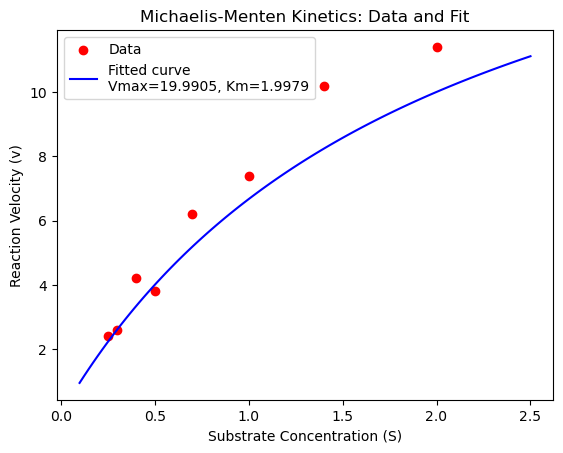

In [ ]:
def michaelis_menten(V_max, K_M, S):
    return (V_max * S) / (K_M + S)

def error_function(params, S, v):
    V_max, K_M = params
    return np.sum((v - michaelis_menten(V_max, K_M, S))**2)

def gradient(params, S, v):
    V_max, K_M = params
    grad_V_max = -2 * np.sum(S * (v - michaelis_menten(V_max, K_M, S)) / (K_M + S))
    grad_K_M = 2 * np.sum((v - michaelis_menten(V_max, K_M, S)) * V_max * S / (K_M + S)**2)
    return np.array([grad_V_max, grad_K_M])

def hessian(params, S, v):
    V_max, K_M = params
    H11 = 2 * np.sum((S / (K_M + S))**2)
    H12 = 2 * np.sum((S / (K_M + S)**2) * (v - 2 * V_max * S / (K_M + S)))
    H21 = H12
    H22 = 2 * np.sum((V_max * S / (K_M + S)**3) * (3 * michaelis_menten(V_max, K_M, S) - 2 * v))
    return np.array([[H11, H12], [H21, H22]])

def golden_section_search(func, params, S, v, tol=1e-5):
    # Expand the bounds of the search for larger step sizes
    a, b = 0.0, 10.0  # Adjusted step size bounds
    phi = (1 + np.sqrt(5)) / 2  # Golden ratio
    while (b - a) > tol:
        c = b - (b - a) / phi
        d = a + (b - a) / phi
        if func(params + c * gradient(params, S, v), S, v) < func(params + d * gradient(params, S, v), S, v):
            b = d
        else:
            a = c
    return (a + b) / 2

# Define the Newton's method for parameter optimization
def newton_method(S, v, initial_guess, max_iter=100, tol=1e-6):
    params = initial_guess
    for iteration in range(max_iter):
        grad = gradient(params, S, v)
        H = hessian(params, S, v)
        
        # Compute the Newton step
        delta = np.linalg.solve(H, grad)
        
        # Apply Golden Section Search for step size
        step_size = golden_section_search(error_function, params, S, v)
        
        # Update the parameters
        params = params - step_size * delta
        
        # Debug: Print the step size and parameter updates
        print(f"Iteration {iteration}:")
        print(f"    Parameters: Vmax={params[0]}, Km={params[1]}")
        print(f"    Gradient: {grad}")
        print(f"    Step size: {step_size}")
        
        # Check for convergence
        if np.linalg.norm(delta) < tol:
            print("Converged!")
            break
    
    return params

# Data from Wong (1975)
S = np.array([0.25, 0.3, 0.4, 0.5, 0.7, 1.0, 1.4, 2.0])  # Substrate concentrations
v = np.array([2.4, 2.6, 4.2, 3.8, 6.2, 7.4, 10.2, 11.4])  # Reaction velocities

# Initial guesses for Vmax and Km
initial_guess = [20, 2]

# Apply Newton's Method to find optimal Vmax and Km
optimal_params = newton_method(S, v, initial_guess)

# Display the results
Vmax_opt, Km_opt = optimal_params
print(f"Optimal Vmax: {Vmax_opt:.4f}")
print(f"Optimal Km: {Km_opt:.4f}")

# Plot the data and the fitted curve
S_fine = np.linspace(0.1, 2.5, 100)
v_fitted = michaelis_menten(Vmax_opt, Km_opt, S_fine)

plt.scatter(S, v, label="Data", color='red')
plt.plot(S_fine, v_fitted, label=f"Fitted curve\nVmax={Vmax_opt:.4f}, Km={Km_opt:.4f}", color='blue')
plt.xlabel('Substrate Concentration (S)')
plt.ylabel('Reaction Velocity (v)')
plt.legend()
plt.title("Michaelis-Menten Kinetics: Data and Fit")
plt.show()


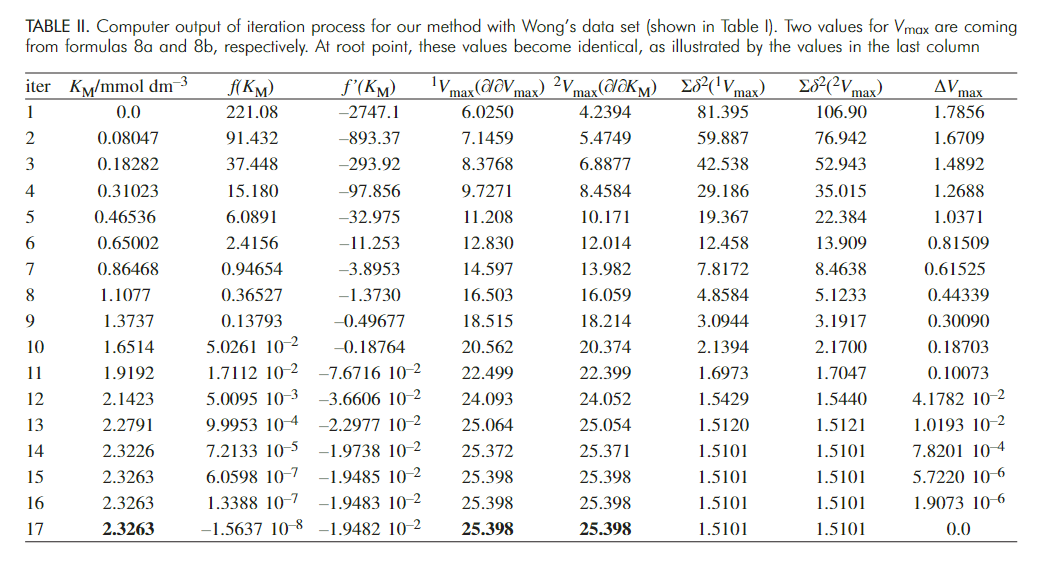